In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =5e-25

nband = 115

ng =4

ng_refs = (/ 4 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 1100

data w_diffuse
     &     /1.66 , 1.66 , 1.7 , 1.8/

data wgt
     &     /0.3 , 0.45 , 0.6 , 0.95/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

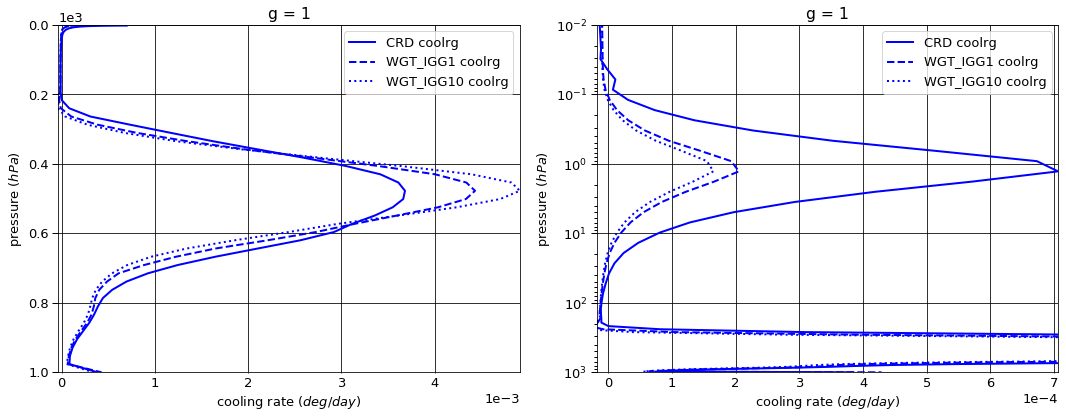

# Figure: cooling rate g-group 2

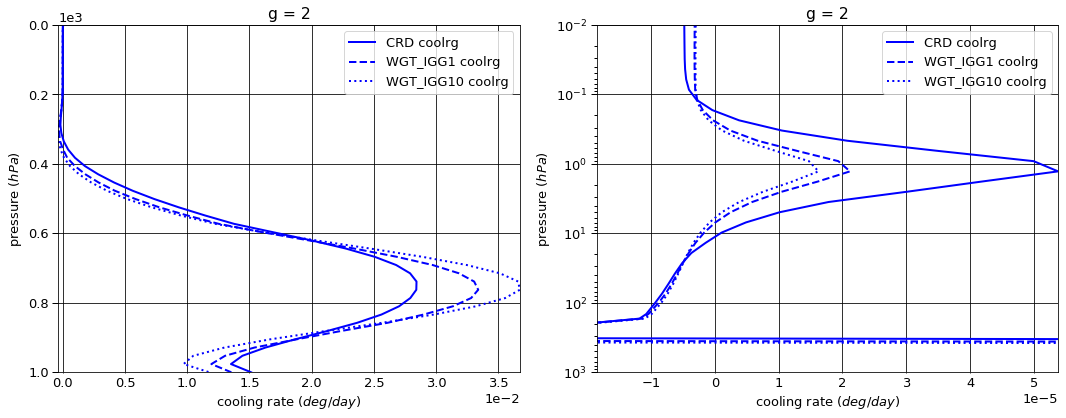

# Figure: cooling rate g-group 3

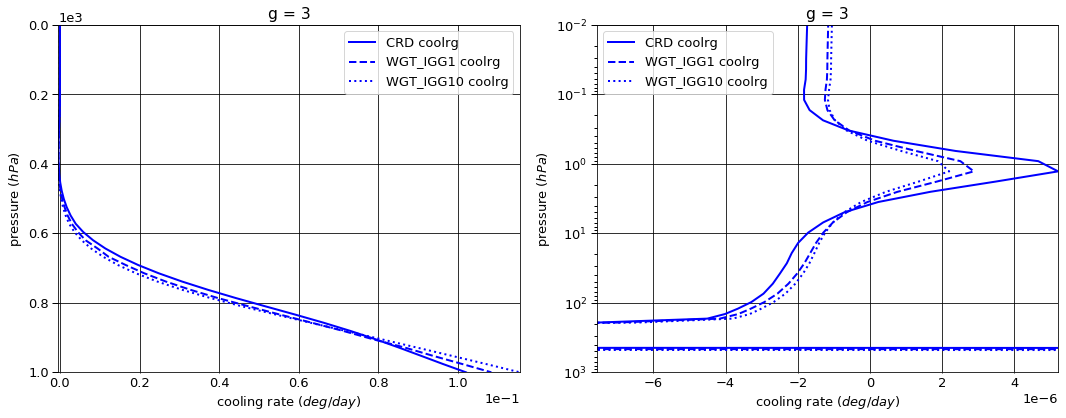

# Figure: cooling rate g-group 4

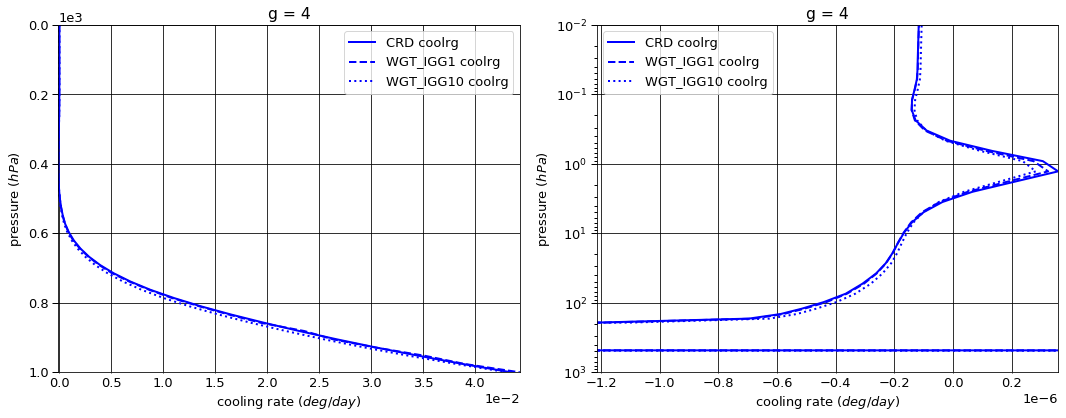

# Figure: cooling rate g-group total

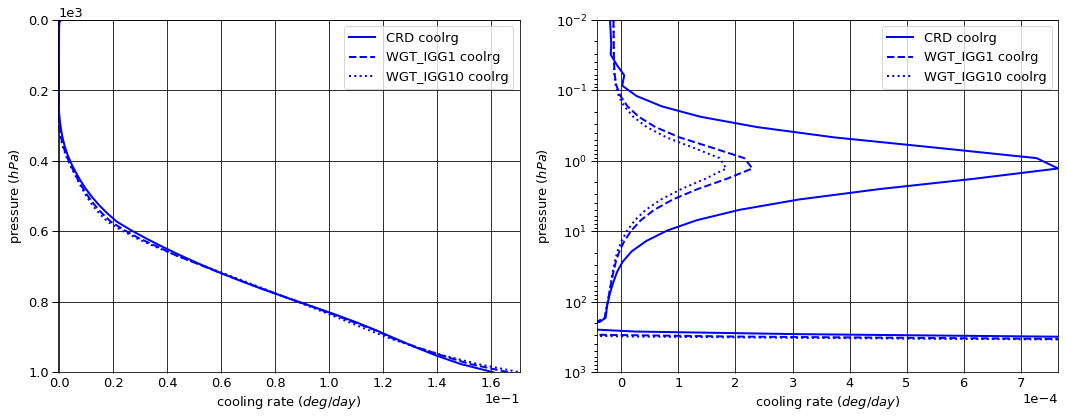

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.145643  0.000000  -0.145643
  1013.0   76     -0.353340  0.352288  -0.001051
2 0.0      1      -1.400618  0.000000  -1.400618
  1013.0   76     -2.025206  1.910424  -0.114781
3 0.0      1      -7.564058  0.000000  -7.564058
  1013.0   76     -8.094364  3.089370  -5.004994
4 0.0      1     -12.668144  0.000000 -12.668144
  1013.0   76    -12.796750  0.946521 -11.850229


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.144942  0.000000  -0.144942
  1013.0   76     -0.353340  0.352201  -0.001139
2 0.0      1      -1.404778  0.000000  -1.404778
  1013.0   76     -2.025206  1.953555  -0.071650
3 0.0      1      -7.614826  0.000000  -7.614826
  1013.0   76     -8.094364  2.956955  -5.137409
4 0.0      1     -12.670348  0.000000 -12.670348
  1013.0   76    -12.796750  0.944490 -11.852260


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.143863  0.000000  -0.143863
  1013.0   76     -0.353340  0.352444  -0.000896
2 0.0      1      -1.400804  0.000000  -1.400804
  1013.0   76     -2.025206  1.970420  -0.054786
3 0.0      1      -7.641373  0.000000  -7.641373
  1013.0   76     -8.094364  2.940046  -5.154317
4 0.0      1     -12.679171  0.000000 -12.679171
  1013.0   76    -12.796750  0.896205 -11.900545


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000700  0.000000  0.000700
  1013.0   76     0.000000 -0.000088 -0.000088
2 0.0      1     -0.004160  0.000000 -0.004160
  1013.0   76     0.000000  0.043131  0.043131
3 0.0      1     -0.050768  0.000000 -0.050768
  1013.0   76     0.000000 -0.132415 -0.132415
4 0.0      1     -0.002204  0.000000 -0.002204
  1013.0   76     0.000000 -0.002032 -0.002031


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001780  0.000000  0.001780
  1013.0   76     0.000000  0.000155  0.000155
2 0.0      1     -0.000186  0.000000 -0.000186
  1013.0   76     0.000000  0.059995  0.059995
3 0.0      1     -0.077315  0.000000 -0.077315
  1013.0   76     0.000000 -0.149323 -0.149323
4 0.0      1     -0.011027  0.000000 -0.011027
  1013.0   76     0.000000 -0.050316 -0.050316

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.853379e-05
  1001.112500 75     3.845632e-04
2 0.000312    1     -4.804954e-06
  1001.112500 75     1.513513e-02
3 0.000312    1     -1.658818e-06
  1001.112500 75     1.019938e-01
4 0.000312    1     -1.088419e-07
  1001.112500 75     4.345772e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.055524e-05
  1001.112500 75     4.291154e-04
2 0.000312    1     -3.063147e-06
  1001.112500 75     1.354507e-02
3 0.000312    1     -1.098109e-06
  1001.112500 75     1.083673e-01
4 0.000312    1     -1.078572e-07
  1001.112500 75     4.429536e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.047409e-05
  1001.112500 75     3.416291e-04
2 0.000312    1     -2.874439e-06
  1001.112500 75     1.178259e-02
3 0.000312    1     -9.973731e-07
  1001.112500 75     1.155229e-01
4 0.000312    1     -9.937946e-08
  1001.112500 75     4.310307e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      7.978550e-06
  1001.112500 75     4.455215e-05
2 0.000312    1      1.741806e-06
  1001.112500 75    -1.590058e-03
3 0.000312    1      5.607087e-07
  1001.112500 75     6.373450e-03
4 0.000312    1      9.846700e-10
  1001.112500 75     8.376410e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      8.059704e-06
  1001.112500 75    -4.293411e-05
2 0.000312    1      1.930515e-06
  1001.112500 75    -3.352538e-03
3 0.000312    1      6.614450e-07
  1001.112500 75     1.352903e-02
4 0.000312    1      9.462427e-09
  1001.112500 75    -3.546480e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.778462,0.000000,-21.778462
1013.0,76,-23.269659,6.298604,-16.971056



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.834894,0.000000,-21.834894
1013.0,76,-23.269659,6.207201,-17.062458



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.865211,0.000000,-21.865211
1013.0,76,-23.269659,6.159115,-17.110544



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.056432,0.000000,-0.056432
1013.0,76,0.000000,-0.091403,-0.091403



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.086749,0.000000,-0.086749
1013.0,76,0.000000,-0.139488,-0.139489


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000025
1001.112500,75,0.160971



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000015
1001.112500,75,0.166637



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.170750



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000010
1001.112500,75,0.005666



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000011
1001.112500,75,0.009779


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015957,0.014906
2,0.089391,0.086202
3,0.357652,0.344282
4,0.537000,0.554611


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.089438e-22
2,7.380948e-24
3,5.000596e-25
4,3.773541e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.089438e-22,NaN,0.015957,0.014906,0.015957,0.014906,600.0
2,7.380948e-24,0.067750,0.089391,0.086202,0.105348,0.101108,600.0
3,5.000596e-25,0.067750,0.357652,0.344282,0.463000,0.445389,600.0
4,3.773541e-26,0.075462,0.537000,0.554611,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.357810e-22  5.721667e-24  41.208439  6.364898e-09
      2 0.000312     3.217788e-24  1.336866e-25  24.069640  1.295754e-10
      3 0.000312     1.356944e-25  8.932259e-27  15.191499  7.237807e-12
      4 0.000312     5.043237e-27  3.654019e-28  13.801888  4.095693e-13
2     1 0.000750     2.373202e-22  5.731912e-24  41.403318  2.579781e-09
      2 0.000750     3.239125e-24  1.340436e-25  24.164700  5.252734e-11
      3 0.000750     1.364942e-25  8.962899e-27  15.228802  2.932174e-12
      4 0.000750     5.077016e-27  3.668819e-28  13.838286  1.660724e-13
3     1 0.001052     2.406147e-22  5.751444e-24  41.835534  3.666051e-09
      2 0.001052     3.284764e-24  1.347545e-25  24.375910  7.467035e-11
      3 0.001052     1.382061e-25  9.025839e-27  15.312270  4.162658e-12
      4 0.001052     5.149509e-27  3.698945e-28  13.921561  2.362176e-13
4     1 0.001476     2.441396e-22  5.772706e-24  42.292055  5.215440e-09
      2 0.001476     3.333716e-24  1.355203e-25  24.599373  1.062694e-10
      3 0.001476     1.400414e-25  9.093123e-27  15.400800  5.915889e-12
      4 0.001476     5.227591e-27  3.731248e-28  14.010300  3.364046e-13
5     1 0.002070     2.477059e-22  5.794853e-24  42.745851  7.417846e-09
      2 0.002070     3.383382e-24  1.363054e-25  24.822064  1.512085e-10
      3 0.002070     1.419025e-25  9.161368e-27  15.489230  8.405833e-12
      4 0.002070     5.307159e-27  3.764156e-28  14.099201  4.790071e-13
6     1 0.002904     2.513104e-22  5.818162e-24  43.194126  1.055103e-08
      2 0.002904     3.433734e-24  1.371155e-25  25.042635  2.151735e-10
      3 0.002904     1.437884e-25  9.230790e-27  15.577042  1.194510e-11
      4 0.002904     5.388182e-27  3.797814e-28  14.187589  6.821636e-13
7     1 0.004074     2.549529e-22  5.843048e-24  43.633549  1.500748e-08
      2 0.004074     3.484790e-24  1.379601e-25  25.259407  3.062054e-10
      3 0.004074     1.456995e-25  9.301790e-27  15.663594  1.697513e-11
      4 0.004074     5.470706e-27  3.832478e-28  14.274594  9.715551e-13
8     1 0.005714     2.586331e-22  5.870096e-24  44.059433  2.134408e-08
      2 0.005714     3.536575e-24  1.388526e-25  25.470003  4.357245e-10
      3 0.005714     1.476364e-25  9.374943e-27  15.747977  2.412193e-11
      4 0.005714     5.554784e-27  3.868510e-28  14.358975  1.383696e-12
9     1 0.008015     2.623510e-22  5.900134e-24  44.465269  3.035611e-08
      2 0.008015     3.589129e-24  1.398120e-25  25.671103  6.200571e-10
      3 0.008015     1.496003e-25  9.451074e-27  15.828921  3.427917e-11
      4 0.008015     5.640496e-27  3.906435e-28  14.438984  1.970839e-12
10    1 0.011243     2.661052e-22  5.934319e-24  44.841744  4.317158e-08
      2 0.011243     3.642483e-24  1.408652e-25  25.857923  8.823900e-10
      3 0.011243     1.515917e-25  9.531322e-27  15.904587  4.871391e-11
      4 0.011243     5.727904e-27  3.946981e-28  14.512113  2.807274e-12
11    1 0.015771     2.698936e-22  5.974279e-24  45.175923  6.139715e-08
      2 0.015771     3.696680e-24  1.420501e-25  26.023780  1.255799e-09
      3 0.015771     1.536115e-25  9.617308e-27  15.972402  6.923043e-11
      4 0.015771     5.817091e-27  3.991185e-28  14.574847  3.999062e-12
12    1 0.022122     2.737154e-22  6.022303e-24  45.450282  8.731596e-08
      2 0.022122     3.751812e-24  1.434204e-25  26.159533  1.787375e-09
      3 0.022122     1.556618e-25  9.711360e-27  16.028838  9.839241e-11
      4 0.022122     5.908216e-27  4.040537e-28  14.622353  5.697327e-12
13    1 0.031031     2.775698e-22  6.081591e-24  45.640994  1.241787e-07
      2 0.031031     3.808007e-24  1.450524e-25  26.252621  2.544324e-09
      3 0.031031     1.577457e-25  9.816767e-27  16.069010  1.398501e-10
      4 0.031031     6.001501e-27  4.097153e-28  14.647978  8.117845e-12
14    1 0.043528     2.817089e-22  6.158038e-24  45.746528  1.767638e-07
      2 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
